In [1]:
import json
import glob

In [2]:
!pip install imagesize

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [20]:
import os
#base_dir = '/media/anbang/Crucial X6/haihua_garbage_dataset/complex_open_data/train/images/datasets/coco/train2017/'
base_dir = '/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/'
annotation_files = glob.glob(base_dir+'images_withoutrect/*.json')
annotated_images = [s.replace('.json','.png') for s in annotation_files]
all_images = list(set(glob.glob(base_dir+'images_withoutrect/*'))-set(annotation_files))


In [21]:
print(len(annotation_files),len(annotated_images),len(all_images))

19990 19990 20000


In [22]:
import imagesize
import tqdm

In [23]:
from collections import defaultdict

annotation_seg = defaultdict(list)
cnt=0
segment_statistics = defaultdict(int)
for annotation_file in tqdm.tqdm(annotation_files):
    with open(annotation_file, 'r') as f:
        annotation = json.load(f)
        #print(annotation)
        for item in annotation:
            width, height = imagesize.get(base_dir+'images_withoutrect/%s'%item['filename'])
            segment_statistics[len(item['segmentation'])]+=1
            if len(item['segmentation'])>1:
                continue
            for region in range(len(item['segmentation'])):
                annotation_seg[item['filename']].append({'segmentation':[t/(width if i%2==0 else height) for i,t in enumerate(item['segmentation'][region])],'bbox':item['bbox']})
        

100%|████████████████████████████████████| 19990/19990 [01:11<00:00, 278.43it/s]


In [24]:
segment_statistics

defaultdict(int,
            {2: 918,
             1: 21875,
             3: 293,
             4: 129,
             5: 49,
             17: 1,
             9: 6,
             6: 21,
             7: 15,
             8: 2,
             10: 3,
             11: 1})

In [31]:
len(annotation_seg)

19313

In [33]:
with open('./buffed_annotation.json', 'w') as f:
    json.dump(annotation_seg,f)

In [34]:
with open('./buffed_annotation.json', 'r') as f:
    annotation_seg = json.load(f)

print(len(annotation_seg))
#print(annotation_seg.keys())
print(annotation_seg['0a224fad7309.png'])

4853


KeyError: '0a224fad7309.png'

In [25]:
with open(base_dir+'/train.json', 'r') as f:
    annotation_haihua = json.load(f)


In [26]:
print(annotation_haihua.keys())
print(len(annotation_haihua['annotations']))
print(annotation_haihua['annotations'][0])
print(len(annotation_haihua['images']))
print(annotation_haihua['images'][0])
file_name_to_image_id = {}
for im_info in annotation_haihua['images']:
    file_name_to_image_id[im_info['file_name'].split('/')[-1]]=im_info['image_id']
    
image_id_to_objects = defaultdict(list)
for anno_info in annotation_haihua['annotations']:
    image_id_to_objects[anno_info['image_id']].append(anno_info)
    


dict_keys(['info', 'lincenses', 'images', 'type', 'annotations', 'categories'])
80000
{'area': 81909.20209190401, 'iscrowd': 0, 'image_id': 11003, 'bbox': [636.08832, 305.77176, 298.5888, 274.32108000000005], 'category_id': 2}
80000
{'file_name': 'images_withoutrect/11003.png', 'height': 1080, 'width': 1920, 'image_id': 11003}


In [27]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [28]:
total = 0
found = 0
import copy
to_write = {}
category_statistics = defaultdict(int)
for file_name in tqdm.tqdm(annotation_seg.keys()):
    #print(file_name)
    new_annotation = []
    gt_annotations = image_id_to_objects[file_name_to_image_id[file_name]]
    for gt_anno in gt_annotations:
        total+=1
        best_fit = [0,0]
        for item in annotation_seg[file_name]:
            bbox_gt = {'x1':gt_anno['bbox'][0], 'x2':gt_anno['bbox'][0]+gt_anno['bbox'][2], 'y1':gt_anno['bbox'][1], 'y2':gt_anno['bbox'][1]+gt_anno['bbox'][3]}
            bbox_seg = {'x1':item['bbox'][0], 'x2':item['bbox'][0]+item['bbox'][2], 'y1':item['bbox'][1], 'y2':item['bbox'][1]+item['bbox'][3]}
            if get_iou(bbox_gt,bbox_seg)>max(0.65,best_fit[0]):
                best_fit[1]=[gt_anno['category_id']]
                best_fit[1].extend(item['segmentation'])
                best_fit[0]=get_iou(bbox_gt,bbox_seg)
        if best_fit[0]>0:
            category_statistics[best_fit[1][0]]+=1
            found+=1
            new_annotation.append(best_fit[1])
    if len(new_annotation)>0:
        to_write[file_name.split('.')[0]]=copy.deepcopy(new_annotation)
        
    
print("found items:",found)
print("fail to find:",total-found)

100%|██████████████████████████████████| 19313/19313 [00:00<00:00, 22365.23it/s]

found items: 17732
fail to find: 1581


In [30]:
import shutil
dst_dir = '/media/anbang/Crucial X6/haihua_garbage_dataset/haihua_custom/train/'
for file_id in tqdm.tqdm(to_write.keys()):
    for item in to_write[file_id]:
        if len(item)<=4:
            print(file_id)
    s = '\n'.join([' '.join([str(t) for t in s_]) for s_ in to_write[file_id]])
    with open(base_dir+'images_withoutrect/%s.txt'%file_id, 'w') as f:
        f.write(s)
    shutil.copyfile(base_dir+'images_withoutrect/%s.txt'%file_id,dst_dir+file_id+'.txt')
    shutil.copyfile(base_dir+'images_withoutrect/%s.png'%file_id,dst_dir+file_id+'.png')

100%|█████████████████████████████████████| 17732/17732 [31:08<00:00,  9.49it/s]


In [29]:
category_statistics

defaultdict(int,
            {172: 139,
             196: 193,
             178: 120,
             46: 160,
             171: 86,
             136: 67,
             180: 175,
             181: 163,
             7: 177,
             128: 116,
             81: 37,
             38: 104,
             132: 45,
             4: 141,
             59: 87,
             57: 116,
             29: 183,
             35: 137,
             187: 164,
             83: 127,
             165: 150,
             37: 179,
             94: 153,
             27: 202,
             93: 31,
             195: 152,
             47: 152,
             79: 103,
             106: 75,
             56: 129,
             182: 144,
             8: 178,
             163: 134,
             179: 166,
             108: 153,
             63: 60,
             1: 141,
             85: 126,
             100: 100,
             153: 103,
             185: 40,
             43: 181,
             13: 171,
             16: 101,
        

In [56]:
print(len(glob.glob(base_dir+'images_withoutrect/*.txt')))
print(len(to_write))
print(len(glob.glob(dst_dir+'*')))

2988
2988
14240


In [55]:
import glob
import shutil
import random
val_dir = '/media/anbang/Crucial X6/haihua_garbage_dataset/haihua_custom/val/'
file_list = glob.glob(dst_dir+'*.txt')
random.shuffle(file_list)
for txt_file in file_list[:100]:
    shutil.move(txt_file,val_dir+txt_file.split('/')[-1])
    png_file = str(txt_file).replace('.txt','.png')
    shutil.move(png_file,val_dir+png_file.split('/')[-1])

In [1]:
import glob
import shutil
import random
val_dir = '/media/anbang/Crucial X6/haihua_garbage_dataset/haihua_custom/val/'
train_file_list = [s.split('/')[-1] for s in glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/haihua_custom/train/'+'*.png')]
all_file_list = [s.split('/')[-1] for s in glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/complex_open_data/train/images/datasets/coco/train2017/images_withoutrect/'+'*.png')]
test_file_list = list(set(all_file_list)-set(train_file_list))
print(len(test_file_list))
for file in test_file_list:
    shutil.move('/media/anbang/Crucial X6/haihua_garbage_dataset/complex_open_data/train/images/datasets/coco/train2017/images_withoutrect/'+file,val_dir+file)
    

7


In [3]:
len(all_file_list)

2999

In [7]:
for file_path in glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.json'):
    try:
        os.remove(file_path)
    except OSError as e:
        print("Error: %s : %s" % (file_path, e.strerror))

In [11]:
hist= []
for image_file in tqdm.tqdm(annotation_seg.keys()):
    with open('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/'+image_file.replace('.png','.txt'), 'w') as f:
        s = ""
        for i,item in enumerate(annotation_seg[image_file]):
            if i!=0:
                s+='\n'
            category = image_id_to_category[file_name_to_image_id[image_file]]
            hist.append(category)
            s+=str(category)+' '+' '.join([str(t) for t in item])
        f.write(s)
    
        

100%|█████████████████████████████████████| 48136/48136 [14:43<00:00, 54.46it/s]


In [22]:
import os
l1 = glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.txt')
l2 = [s.replace('.txt','.png') for s in l1]
l3 = glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.png')
rem = list(set(l3)-set(l3).intersection(set(l2)))
print(len(rem))
for file_path in rem:
    try:
        os.remove(file_path)
    except OSError as e:
        print("Error: %s : %s" % (file_path, e.strerror))


        

l1 = glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.txt')
l3 = glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.png')
l2 = [s.replace('.png','.txt') for s in l3]
rem = list(set(l1)-set(l1).intersection(set(l2)))
print(len(rem))


for file_path in rem:
    try:
        os.remove(file_path)
    except OSError as e:
        print("Error: %s : %s" % (file_path, e.strerror))



29442
4129


In [26]:
print(len(glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.txt')))
print(len(glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.png')))

44007
44007


In [27]:
annotation_haihua['categories']

[{'id': 1, 'name': '瓜子壳'},
 {'id': 2, 'name': '核桃'},
 {'id': 3, 'name': '花生壳'},
 {'id': 4, 'name': '毛豆壳'},
 {'id': 5, 'name': '西瓜子'},
 {'id': 6, 'name': '枣核'},
 {'id': 7, 'name': '话梅核'},
 {'id': 8, 'name': '苹果皮'},
 {'id': 9, 'name': '柿子皮'},
 {'id': 10, 'name': '西瓜皮'},
 {'id': 11, 'name': '香蕉皮'},
 {'id': 12, 'name': '柚子皮'},
 {'id': 13, 'name': '荔枝壳'},
 {'id': 14, 'name': '芒果皮'},
 {'id': 15, 'name': '苹果核'},
 {'id': 16, 'name': '干果'},
 {'id': 17, 'name': '桔子皮'},
 {'id': 18, 'name': '饼干'},
 {'id': 19, 'name': '面包'},
 {'id': 20, 'name': '糖果'},
 {'id': 21, 'name': '宠物饲料'},
 {'id': 22, 'name': '风干食品'},
 {'id': 23, 'name': '蜜饯'},
 {'id': 24, 'name': '肉干'},
 {'id': 25, 'name': '冲泡饮料粉'},
 {'id': 26, 'name': '奶酪'},
 {'id': 27, 'name': '罐头'},
 {'id': 28, 'name': '糕饼'},
 {'id': 29, 'name': '薯片'},
 {'id': 30, 'name': '树叶'},
 {'id': 31, 'name': '杂草'},
 {'id': 32, 'name': '绿植'},
 {'id': 33, 'name': '鲜花'},
 {'id': 34, 'name': '豆类'},
 {'id': 35, 'name': '动物内脏'},
 {'id': 36, 'name': '绿豆饭'},
 {'id': 37, '

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8sd0yqs0 because the default path (/home/anbang/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


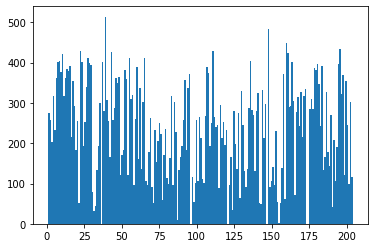

In [28]:
import matplotlib.pyplot as plt

plt.hist(hist,bins=204)
plt.show()

In [33]:
import shutil

nc = 60

TACO_labels = ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass', 'Food Can', 'Aerosol', 'Drink can', 'Toilet tube', 'Other carton', 'Egg carton', 'Drink carton', 'Corrugated carton', 'Meal carton', 'Pizza box', 'Paper cup', 'Disposable plastic cup', 'Foam cup', 'Glass cup', 'Other plastic cup', 'Food waste', 'Glass jar', 'Plastic lid', 'Metal lid', 'Other plastic', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastified paper bag', 'Plastic film', 'Six pack rings', 'Garbage bag', 'Other plastic wrapper', 'Single-use carrier bag', 'Polypropylene bag', 'Crisp packet', 'Spread tub', 'Tupperware', 'Disposable food container', 'Foam food container', 'Other plastic container', 'Plastic glooves', 'Plastic utensils', 'Pop tab', 'Rope & strings', 'Scrap metal', 'Shoe', 'Squeezable tube', 'Plastic straw', 'Paper straw', 'Styrofoam piece', 'Unlabeled litter', 'Cigarette']
TACO_id_to_label = {}
for i,l in enumerate(TACO_labels):
    TACO_id_to_label[i]=l
map_TACO_to_haihua = {'Aluminium foil':88,'Battery':138,'Aluminium blister pack':101,
                      'Other plastic bottle':99,'Clear plastic bottle':99,'Glass bottle':77,
                      'Broken glass':68,'Food Can':27,'Drink can':85,'Egg carton':103,
                      'Meal carton':118,'Disposable plastic cup':116,'Foam cup':116,'Glass cup':72,
                      'Other plastic cup':116,'Glass jar':70,'Magazine paper':73,'Tissues':171,
                      'Paper bag':80,'Plastified paper bag':80, 'Plastic film':101,'Foam food container':103,
                      'Cigarette':200}
images_JPG = glob.glob('/home/anbang/free_study/Auto-Annotate/TACO/TACO/data/train/*.JPG')
images_jpg = glob.glob('/home/anbang/free_study/Auto-Annotate/TACO/TACO/data/train/*.jpg')

for label_file in tqdm.tqdm(glob.glob('/home/anbang/free_study/Auto-Annotate/TACO/TACO/data/train/*.txt')):
    with open(label_file) as f:
        s = f.read()
        s_ = ""
        for i,t in enumerate(s.split('\n')):
            tag = TACO_id_to_label[int(t.split(' ')[0])]
            if tag in map_TACO_to_haihua:
                if i!=0:
                    s_+='\n'
                s_+=str(map_TACO_to_haihua[tag])+' '+' '.join(t.split(' ')[1:])
        if s_=="":
            continue
        image_id = label_file.split('/')[-1].replace('.txt','')
        with open('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/%s.txt'%image_id,'w') as f_:
            f_.write(s_)
        if '/home/anbang/free_study/Auto-Annotate/TACO/TACO/data/train/%s.JPG'%image_id in images_JPG:
            shutil.copyfile('/home/anbang/free_study/Auto-Annotate/TACO/TACO/data/train/%s.JPG'%image_id, '/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/%s.JPG'%image_id)
        else:
            shutil.copyfile('/home/anbang/free_study/Auto-Annotate/TACO/TACO/data/train/%s.jpg'%image_id, '/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/%s.jpg'%image_id)
        
        
        
        

100%|███████████████████████████████████████| 1275/1275 [01:41<00:00, 12.60it/s]


In [35]:
print([t['name'] for t in annotation_haihua['categories']])

['瓜子壳', '核桃', '花生壳', '毛豆壳', '西瓜子', '枣核', '话梅核', '苹果皮', '柿子皮', '西瓜皮', '香蕉皮', '柚子皮', '荔枝壳', '芒果皮', '苹果核', '干果', '桔子皮', '饼干', '面包', '糖果', '宠物饲料', '风干食品', '蜜饯', '肉干', '冲泡饮料粉', '奶酪', '罐头', '糕饼', '薯片', '树叶', '杂草', '绿植', '鲜花', '豆类', '动物内脏', '绿豆饭', '谷类及加工物', '贝类去硬壳', '虾', '面食', '肉类', '五谷杂粮', '排骨-小肋排', '鸡', '鸡骨头', '螺蛳', '鸭', '鱼', '菜根', '菜叶', '菌菇类', '鱼鳞', '调料', '茶叶渣', '咖啡渣', '粽子', '动物蹄', '小龙虾', '蟹壳', '酱料', '鱼骨头', '蛋壳', '中药材', '中药渣', '镜子', '玻璃制品', '窗玻璃', '碎玻璃片', '化妆品玻璃瓶', '食品及日用品玻璃瓶罐', '保温杯', '玻璃杯', '图书期刊', '报纸', '食品外包装盒', '鞋盒', '利乐包', '广告单', '打印纸', '购物纸袋', '日历', '快递纸袋', '信封', '烟盒', '易拉罐', '金属制品', '吸铁石', '铝制品', '金属瓶罐', '金属工具', '罐头盒', '勺子', '菜刀', '叉子', '锅', '金属筷子', '数据线', '塑料玩具', '矿泉水瓶', '塑料泡沫', '塑料包装', '硬塑料', '一次性塑料餐盒餐具', '电线', '塑料衣架', '密胺餐具', '亚克力板', 'PVC管', '插座', '化妆品塑料瓶', '篮球', '足球', 'KT板', '食品塑料盒', '食用油桶', '塑料杯', '塑料盆', '一次性餐盒', '废弃衣服', '鞋', '碎布', '书包', '床上用品', '棉被', '丝绸手绢', '枕头', '毛绒玩具', '皮带', '电路板', '充电宝', '木制品', '优盘', '灯管灯泡', '节能灯', '二极管', '纽扣电池', '手机电池', '镍镉电池', '锂电池', '蓄电池', '胶卷', '照片', 

In [36]:
import random
training_data = glob.glob('/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/images_withoutrect/*.png')
testing = random.sample(training_data,1000)
val = random.sample(testing,100)
testing = list(set(testing)-set(val))
for f in testing:
    shutil.move(f,'/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/testing/%s'%(f.split('/')[-1]))
    shutil.move(f.replace('png','txt'),'/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/testing/%s.txt'%(f.split('/')[-1].split('.')[0]))
for f in val:
    shutil.move(f,'/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/val/%s'%(f.split('/')[-1]))
    shutil.move(f.replace('png','txt'),'/media/anbang/Crucial X6/haihua_garbage_dataset/single_data/images_withoutrect/val/%s.txt'%(f.split('/')[-1].split('.')[0]))
    

In [37]:
['Dummy Class','瓜子壳', '核桃', '花生壳', '毛豆壳', '西瓜子', '枣核', '话梅核', '苹果皮', '柿子皮', '西瓜皮', '香蕉皮', '柚子皮', '荔枝壳', '芒果皮', '苹果核', '干果', '桔子皮', '饼干', '面包', '糖果', '宠物饲料', '风干食品', '蜜饯', '肉干', '冲泡饮料粉', '奶酪', '罐头', '糕饼', '薯片', '树叶', '杂草', '绿植', '鲜花', '豆类', '动物内脏', '绿豆饭', '谷类及加工物', '贝类去硬壳', '虾', '面食', '肉类', '五谷杂粮', '排骨-小肋排', '鸡', '鸡骨头', '螺蛳', '鸭', '鱼', '菜根', '菜叶', '菌菇类', '鱼鳞', '调料', '茶叶渣', '咖啡渣', '粽子', '动物蹄', '小龙虾', '蟹壳', '酱料', '鱼骨头', '蛋壳', '中药材', '中药渣', '镜子', '玻璃制品', '窗玻璃', '碎玻璃片', '化妆品玻璃瓶', '食品及日用品玻璃瓶罐', '保温杯', '玻璃杯', '图书期刊', '报纸', '食品外包装盒', '鞋盒', '利乐包', '广告单', '打印纸', '购物纸袋', '日历', '快递纸袋', '信封', '烟盒', '易拉罐', '金属制品', '吸铁石', '铝制品', '金属瓶罐', '金属工具', '罐头盒', '勺子', '菜刀', '叉子', '锅', '金属筷子', '数据线', '塑料玩具', '矿泉水瓶', '塑料泡沫', '塑料包装', '硬塑料', '一次性塑料餐盒餐具', '电线', '塑料衣架', '密胺餐具', '亚克力板', 'PVC管', '插座', '化妆品塑料瓶', '篮球', '足球', 'KT板', '食品塑料盒', '食用油桶', '塑料杯', '塑料盆', '一次性餐盒', '废弃衣服', '鞋', '碎布', '书包', '床上用品', '棉被', '丝绸手绢', '枕头', '毛绒玩具', '皮带', '电路板', '充电宝', '木制品', '优盘', '灯管灯泡', '节能灯', '二极管', '纽扣电池', '手机电池', '镍镉电池', '锂电池', '蓄电池', '胶卷', '照片', '指甲油瓶', 'X光片', '农药瓶', '杀虫剂及罐', '蜡烛', '墨盒', '染发剂壳', '消毒液瓶', '油漆桶', '药品包装', '药瓶', '废弃针管', '输液管', '口服液瓶', '眼药水瓶', '水银温度计', '水银血压计', '胶囊', '药片', '固体杀虫剂', '甘蔗皮', '坚果壳', '橡皮泥', '毛发', '棉签', '创可贴', '口红', '笔', '纸巾', '胶带', '湿巾', '水彩笔', '打火机', '防碎气泡膜', '榴莲壳', '睫毛膏', '眼影', '仓鼠浴沙', '大骨棒', '旧毛巾', '竹制品', '粉笔', '一次性口罩', '一次性手套', '粉底液', '灰土', '尼龙制品', '尿片', '雨伞', '带胶制品', '牙膏皮', '狗尿布', '椰子壳', '粉扑', '破碗碟', '陶瓷', '卫生纸', '烟头', '假睫毛', '猫砂', '牙刷', '玉米棒']

204